# Hello Bluesky: Reading detectors and scanning

In this notebook you will:

* Connect to some simulated hardware.
* Acquire some data via two common experimental procedures ("plans"), ``count`` and ``scan``.
* Write a custom plan.

Recommend Prerequisites:

* [Hello Python and Jupyter](./Hello%20Python%20and%20Jupyter.ipynb)

## Configuration
Below, we will connect to EPICS IOC(s) controlling simulated hardware in lieu of actual motors and detectors. An EPICS IOC is control system software that allows communication with a wide variety of hardware using a common interface. The IOCs should already be running in the background. Run this command to verify that they are running: it should produce output with RUNNING on each line. In the event of a problem, edit this command to replace `status` with `restart all` and run again.

In [1]:
%matplotlib widget

In [2]:
!supervisorctl -c supervisor/supervisord.conf status

decay                            RUNNING   pid 4872, uptime 0:01:22
mini_beamline                    RUNNING   pid 4873, uptime 0:01:22
random_walk                      RUNNING   pid 4874, uptime 0:01:22
random_walk_horiz                RUNNING   pid 4875, uptime 0:01:22
random_walk_vert                 RUNNING   pid 4876, uptime 0:01:22
simple                           RUNNING   pid 4877, uptime 0:01:22
thermo_sim                       RUNNING   pid 4878, uptime 0:01:22
trigger_with_pc                  RUNNING   pid 4879, uptime 0:01:22


In [3]:
%run scripts/beamline_configuration.py

In [4]:
# aliases for convenience/readability
motor = motor_ph
det = ph

Check that we can communicate with the hardware. If this doesn't raise an error, it worked.

In [5]:
det.wait_for_connection()

## Data Acquisition

### Executing a `count` plan with various parameters

In the example below, the Bluesky run engine is the interpreter of experiment plans and `count` is an experiment plan used here to acquire one reading from a point detector.

In [6]:
from bluesky.plans import count
RE(count([det]))



Transient Scan ID: 6     Time: 2020-06-05 15:44:39
Persistent Unique Scan ID: 'd670305f-c23e-4bfc-8d3d-3c1b8cd14aca'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 15:44:39.3 |      94367 |
+-----------+------------+------------+
generator count ['d670305f'] (scan num: 6)





('d670305f-c23e-4bfc-8d3d-3c1b8cd14aca',)

The return value is a list of the run IDs that uniquely identify this data set. The "scan num" is easier to remember but is not good for long-term reference because it may not be unique.

Let's looks at the documentation for `count` to see what our other options are.

In [7]:
help(count)  # or, equiavently, type count? or ?count

Help on function count in module bluesky.plans:

count(detectors, num=1, delay=None, *, per_shot=None, md=None)
    Take one or more readings from detectors.
    
    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    num : integer, optional
        number of readings to take; default is 1
    
        If None, capture data until canceled
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0.
    per_shot : callable, optional
        hook for customizing action of inner loop (messages per step)
        Expected signature ::
    
           def f(detectors: Iterable[OphydObj]) -> Generator[Msg]:
               ...
    
    md : dict, optional
        metadata
    
    Notes
    -----
    If ``delay`` is an iterable, it must have at least ``num - 1`` entries or
    the plan will raise a ``ValueError`` during iteration.



In [8]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs time')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [9]:
# five consecutive readings
RE(count([det], num=5))



Transient Scan ID: 7     Time: 2020-06-05 15:44:39
Persistent Unique Scan ID: 'f9f82144-c045-4993-9ea4-38b2c37b11e7'
New stream: 'primary'


+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 15:44:39.5 |      93946 |
|         2 | 15:44:39.5 |      93226 |
|         3 | 15:44:39.5 |      93416 |
|         4 | 15:44:39.5 |      93287 |
|         5 | 15:44:39.5 |      93182 |


+-----------+------------+------------+
generator count ['f9f82144'] (scan num: 7)





('f9f82144-c045-4993-9ea4-38b2c37b11e7',)

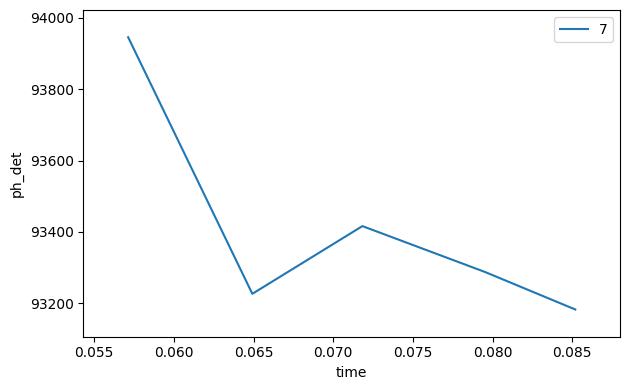

In [10]:
plt.gcf()  # Display a snapshot of the current state of the figure.

In [11]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
# five sequential readings separated by a 1-second delay
RE(count([det], num=5, delay=1))



Transient Scan ID: 8     Time: 2020-06-05 15:44:39
Persistent Unique Scan ID: '8027df84-04dc-4a82-be81-3cd08de4b9d0'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 15:44:40.0 |      93654 |


|         2 | 15:44:41.0 |     100474 |


|         3 | 15:44:42.0 |     102088 |


|         4 | 15:44:43.0 |      96382 |


|         5 | 15:44:44.0 |      93601 |


+-----------+------------+------------+
generator count ['8027df84'] (scan num: 8)





('8027df84-04dc-4a82-be81-3cd08de4b9d0',)

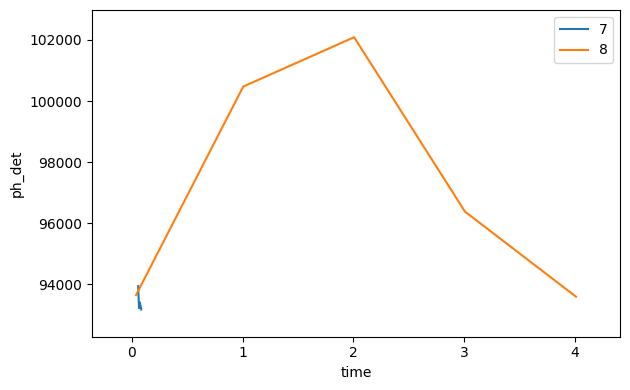

In [13]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Scan

Scan ``motor`` from -10 to 10, stopping at 15 equally-spaced points along the way and reading ``det``.

In [14]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs motor_ph')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [15]:
RE(scan([det], motor, -10, 10, 15))



Transient Scan ID: 9     Time: 2020-06-05 15:44:45
Persistent Unique Scan ID: 'e829cb3f-0e47-4b60-b476-6cbf43724290'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 15:44:45.7 |    -10.000 |      14339 |
|         2 | 15:44:45.7 |     -8.571 |      24046 |
|         3 | 15:44:45.7 |     -7.143 |      37853 |
|         4 | 15:44:45.7 |     -5.714 |      54655 |
|         5 | 15:44:45.8 |     -4.286 |      72923 |
|         6 | 15:44:45.8 |     -2.857 |      89507 |
|         7 | 15:44:45.8 |     -1.429 |     101175 |


|         8 | 15:44:45.8 |      0.000 |     104729 |
|         9 | 15:44:45.8 |      1.429 |     100915 |
|        10 | 15:44:45.8 |      2.857 |      89682 |
|        11 | 15:44:45.8 |      4.286 |      71978 |
|        12 | 15:44:45.8 |      5.714 |      54694 |
|        13 | 15:44:45.9 |      7.143 |      37797 |
|        14 | 15:44:45.9 |      8.571 |      23879 |
|        15 | 15:44:45.9 |     10.000 |      14341 |
+-----------+------------+------------+------------+
generator scan ['e829cb3f'] (scan num: 9)





('e829cb3f-0e47-4b60-b476-6cbf43724290',)

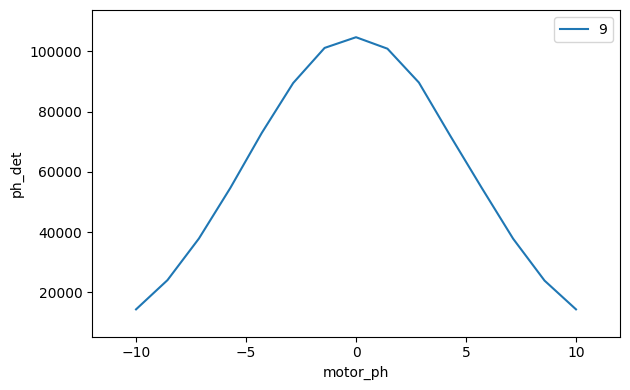

In [16]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Simulators

Bluesky includes utilities to inspecting plans before they are run. You can imagine various reasons you might want to do this. Example:

In [17]:
from bluesky.simulators import summarize_plan

summarize_plan(scan([det], motor, -1, 1, 3))

=================================== Open Run ===================================
motor_ph -> -1.0
  Read ['ph', 'motor_ph']
motor_ph -> 0.0
  Read ['ph', 'motor_ph']
motor_ph -> 1.0
  Read ['ph', 'motor_ph']
================================== Close Run ===================================


### Custom plan

Define a custom "plan", using the Python syntax ``yield from`` to dispatch out to built-in plans.

In [18]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
# The plan_stubs module contains smaller plans.
# They can be used alone or as buildling blocks for larger plans.
from bluesky.plan_stubs import mv


def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        yield from mv(det.exp, t)
        yield from scan([det], motor, -10, 10, 5)
        
RE(sweep_exposure_time([0.01, 0.1, 1]))



Transient Scan ID: 10     Time: 2020-06-05 15:44:46
Persistent Unique Scan ID: '19d0062f-bed8-4780-a0fc-60ca03a9f144'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 15:44:46.7 |    -10.000 |        144 |
|         2 | 15:44:46.8 |     -5.000 |        581 |


|         3 | 15:44:47.0 |      0.000 |       1027 |
|         4 | 15:44:47.1 |      5.000 |        610 |


|         5 | 15:44:47.2 |     10.000 |        133 |
+-----------+------------+------------+------------+
generator scan ['19d0062f'] (scan num: 10)





Transient Scan ID: 11     Time: 2020-06-05 15:44:47
Persistent Unique Scan ID: '630e902c-8041-472f-a4c5-61378dfe3aad'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 15:44:47.8 |    -10.000 |       1301 |
|         2 | 15:44:47.9 |     -5.000 |       5931 |


|         3 | 15:44:48.0 |      0.000 |       9716 |
|         4 | 15:44:48.1 |      5.000 |       5929 |


|         5 | 15:44:48.3 |     10.000 |       1303 |
+-----------+------------+------------+------------+
generator scan ['630e902c'] (scan num: 11)





Transient Scan ID: 12     Time: 2020-06-05 15:44:48
Persistent Unique Scan ID: '40f89fe9-c15b-4621-a6e0-8de42890127b'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 15:44:48.9 |    -10.000 |      13661 |
|         2 | 15:44:49.0 |     -5.000 |      61876 |


|         3 | 15:44:49.1 |      0.000 |     102443 |
|         4 | 15:44:49.2 |      5.000 |      62973 |


|         5 | 15:44:49.4 |     10.000 |      14186 |
+-----------+------------+------------+------------+
generator scan ['40f89fe9'] (scan num: 12)





('19d0062f-bed8-4780-a0fc-60ca03a9f144',
 '630e902c-8041-472f-a4c5-61378dfe3aad',
 '40f89fe9-c15b-4621-a6e0-8de42890127b')

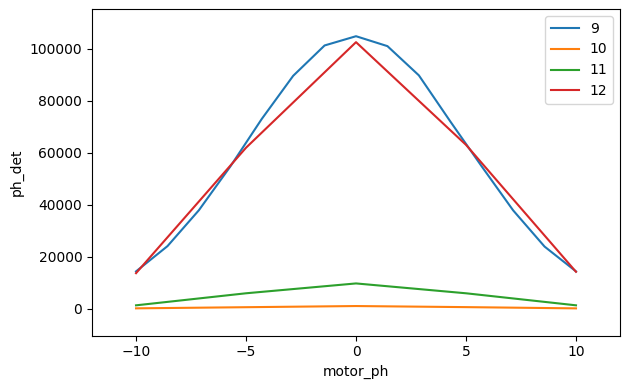

In [20]:
plt.gcf()  # Display a snapshot of the current state of the figure.

## Exercises

Q1: Above we ran a `count` with multiple readings separated by a fixed delay. The ``delay`` parameter also accepts a list of values. Try a `count` with a variable delay.


In [21]:
# Try your solution here. Fill in the blank:
# RE(count(____)))

Execute the following cell to reveal a solution:

In [22]:
%load solutions/count_variable_delay.py

Q2: Write a custom plan that scans the same region twice, first with coarse steps and then with fine steps.

In [23]:
# Try your solution here. Fill in the blank:
# def coarse_and_fine(detectors, motor, start, stop):
#     yield from scan(___)
#     yield from scan(___)
#
# RE(coarse_and_fine([det], motor, -10, 10))

In [24]:
%load solutions/scan_coarse_and_fine.py

Q3. All of the usages of scan we have seen so far scan from negative to positive. Scan from positive to negative.

In [25]:
# Try your solution here.

In [26]:
%load solutions/scan_positive_to_negative.py

Q4: The ``scan`` plan samples equally-spaced points. To sample *arbitrary* points, you can use ``list_scan``. Import it from the same module that we imported ``scan`` from, then use ``list_scan?`` to view its documentation and figure out how to use it. Scan the positions ``[1, 1, 2, 3, 5, 8]``.

In [27]:
# Try your solution here.

In [28]:
%load solutions/scan_fibonacci.py

Q5: What's wrong with this? (What does it do?)

In [29]:
# Broken example
def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        mv(det.exp, t)
        scan([det], motor, -10, 10, 15)

In [30]:
%load solutions/broken_sweep_exposure_time_explanation.txt